# NLP: Yelp Review to Rating
## :)

In [1]:
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

In [2]:
# importing torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) #for reproducibility

In [3]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


### EDA - Stars
Not too much to go off of, but let's get a general understanding of our data. How many nulls do we have?

In [4]:
yelp.isna().sum()

review_id    0
text         0
stars        0
dtype: int64

How large is the data?

In [5]:
yelp.shape

(533581, 3)

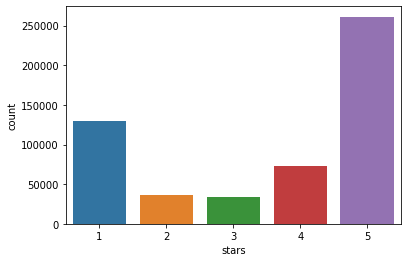

In [6]:
sns.countplot(yelp['stars'])

One thing we can potentially look at is whether or not the reviews are balanced. Let's say >=4 is positive, and <4 is negative. If we do see a significant difference in positive and negative reviews, we can balance it before training.

In [7]:
def pos_or_neg(x):
    if x >= 4:
        return "Positive"
    else:
        return "Negative"
    
yelp['category'] = yelp['stars'].apply(pos_or_neg)
yelp.head()

,review_id,text,stars,category
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1,Negative
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5,Positive
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5,Positive
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5,Positive
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1,Negative


1.6679183395916979

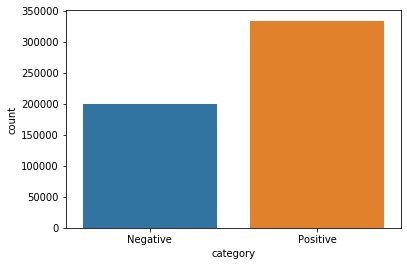

In [8]:
sns.countplot(yelp['category'])
num_pos = np.count_nonzero(yelp['category'] == 'Positive')
num_neg = np.count_nonzero(yelp['category'] == 'Negative')
num_pos / num_neg

There are roughly 1 and 2/3 times as many positive reviews as negative reviews. We will first try no class balancing when building the model, but may turn to class balancing later on.

### Data Cleaning - Text

In [9]:
yelp['text'][17]

'I love chinese food and I love mexican food. What can go wrong? A couple of things. First things first, this place is more of a "rice bowl" kind of place. I thought it was going to be more diverse as far as the menu goes, but its mainly rice bowls you get with different kinds of meats. The ordering was a little confusing at first, but one of the employees helped us out and I got the 2-item bowl and got the jade chicken and hengrenade chicken with all rice(jerk). I also ordered a jade chicken quesadilla on the side.\n\nI\'m gonna admit, this place looks kinda dirty. I don\'t think Arizona uses those health department letter grade system like California does, but if I were to just judge by how it looked inside, i\'d give it a "C" grade lol. We waited for about 15 minutes or so and finally got our food. We took it to go and ate at our hotel room. \n\nMmmm... the food was just alright. The jade chicken was nothing special. It tasted like any generic chinese fast food orange chicken/sesame

In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    text = ' '.join(ps.stem(word) for word in text.split() if word not in STOPWORDS) # delete stopwords from text and stem
    return text
    
yelp['text'] = yelp['text'].apply(clean_text)

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.marketwired.com/press-release/lease-of-spot-concord-place-cafe-terminated-tsx-venture-spp-1950108.htm

Unfortunate!" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the

In [16]:
yelp.to_csv('cleaned_yelp_stemmed.csv')

# Model Implementation

### Evaluation
#### Average Star Error (Average Absolute offset between predicted and true number of stars)

In [ ]:
import keras.backend as K

# def mse(y_true, y_pred):
#     loss = K.square(y_pred - y_true)
#     loss = K.mean(loss, axis=-1)      
#     return loss

def ASE(y_true, y_pred):
    loss = np.abs(y_true - y_pred)
    
    
    return 

### Train/Test Split (Unbalanced and balanced)

In [53]:
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers

yelp = pd.read_csv('cleaned_yelp_stemmed.csv')
yelp.head()

,Unnamed: 0,review_id,text,stars,category
0,0,Q1sbwvVQXV2734tPgoKj4Q,total bill horribl servic 8g crook actual nerv...,1,Negative
1,1,GJXCdrto3ASJOqKeVWPi6Q,ador travi hard rock new kelli cardena salon i...,5,Positive
2,2,2TzJjDVDEuAW6MR5Vuc1ug,say offic realli togeth organ friendli dr j ph...,5,Positive
3,3,yi0R0Ugj_xUx_Nek0-_Qig,went lunch steak sandwich delici caesar salad ...,5,Positive
4,4,11a8sVPMUFtaC7_ABRkmtw,today second three session paid although first...,1,Negative


In [54]:
from sklearn.model_selection import train_test_split

X = yelp['text'].fillna('').values
y = yelp['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### BOW model using simple network

In [55]:
max_words = 2000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(X_train)
X_train = tokenize.texts_to_matrix(X_train)
X_test = tokenize.texts_to_matrix(X_test)

In [56]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [57]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [58]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 2000)
X_test shape: (160075, 2000)
y_train shape: (373506, 5)
y_test shape: (160075, 5)


Here, we are computing a single model, but in future we will optimize on several parameters, listed below
* Batch size
* Learning rate
* Gradient clipping
* Drop out
* Batch normalization
* Optimizers
* Regularization

In [24]:
batch_size = 128
epochs = 3

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 336155 samples, validate on 37351 samples
Epoch 1/3
336155/336155 [==============================] - 141s 419us/step - loss: 0.7156 - accuracy: 0.7273 - val_loss: 0.6582 - val_accuracy: 0.7419
Epoch 2/3
336155/336155 [==============================] - 134s 397us/step - loss: 0.6474 - accuracy: 0.7481 - val_loss: 0.6507 - val_accuracy: 0.7456
Epoch 3/3
336155/336155 [==============================] - 130s 387us/step - loss: 0.6209 - accuracy: 0.7592 - val_loss: 0.6479 - val_accuracy: 0.7449


In [25]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 14s 90us/step
Test accuracy: 0.7502420544624329


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1024512   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2565      
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total params: 1,029,125
Trainable params: 1,028,101
Non-trainable params: 1,024
________________________________________

In [27]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

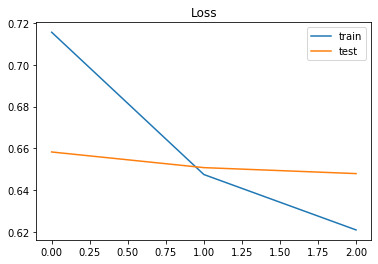

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

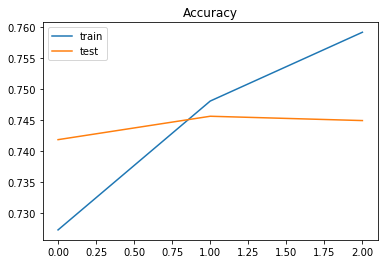

In [29]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Now training with several parameter changes

In [59]:
import itertools

batch_sizes = [128, 256, 512]
epochs = [3]
learning_rates = [.01, .001, .0001]
dropout = [True]
batch_norm = [True]
regularization = [True]
optimizers = ["RMSProp", "ADAM", "Adadelta"]

all_lists = [batch_sizes, epochs, learning_rates, dropout, batch_norm, regularization, optimizers]

params_to_test = list(itertools.product(*all_lists))
print(len(params_to_test))

27


In [61]:
models = {}
histories = {}
scores = {}

for params in params_to_test:
    print(params)
    batch_size, epochs, learning_rate, dropout, batch_norm, regularization, opt = params
    
    if opt == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)
    elif opt == "RMSProp":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)
    elif opt == "ADAM":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99, amsgrad=False)
    else:
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95)
    
    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.1)
    
    models[params] = model
    histories[params] = history
    
    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score)
    
    scores[params] = score

(128, 3, 0.01, True, True, True, 'RMSProp')
Train on 336155 samples, validate on 37351 samples
Epoch 1/3
336155/336155 [==============================] - 116s 344us/step - loss: 0.7226 - accuracy: 0.7283 - val_loss: 0.6808 - val_accuracy: 0.7405
Epoch 2/3
336155/336155 [==============================] - 114s 340us/step - loss: 0.6808 - accuracy: 0.7427 - val_loss: 0.6716 - val_accuracy: 0.7426
Epoch 3/3
160075/160075 [==============================] - 14s 87us/step
[0.6815804430601765, 0.7411150932312012]
(128, 3, 0.01, True, True, True, 'ADAM')
Train on 336155 samples, validate on 37351 samples
Epoch 1/3
336155/336155 [==============================] - 124s 370us/step - loss: 0.7050 - accuracy: 0.7299 - val_loss: 0.6697 - val_accuracy: 0.7375
Epoch 2/3
336155/336155 [==============================] - 106s 315us/step - loss: 0.6526 - accuracy: 0.7475 - val_loss: 0.6649 - val_accuracy: 0.7413
Epoch 3/3
160075/160075 [==============================] - 16s 101us/step
[0.6595521898986808, 

336155/336155 [==============================] - 317s 944us/step - loss: 0.6401 - accuracy: 0.7564 - val_loss: 0.6684 - val_accuracy: 0.7449
Epoch 3/3
160075/160075 [==============================] - 29s 183us/step
[0.6696843283630323, 0.7475433349609375]
(256, 3, 0.001, True, True, True, 'ADAM')
Train on 336155 samples, validate on 37351 samples
Epoch 1/3
336155/336155 [==============================] - 321s 954us/step - loss: 0.6943 - accuracy: 0.7331 - val_loss: 0.6547 - val_accuracy: 0.7439
Epoch 2/3
336155/336155 [==============================] - 263s 782us/step - loss: 0.6173 - accuracy: 0.7610 - val_loss: 0.6477 - val_accuracy: 0.7487
Epoch 3/3
160075/160075 [==============================] - 27s 169us/step
[0.6586733524296297, 0.7467062473297119]
(256, 3, 0.001, True, True, True, 'Adadelta')
Train on 336155 samples, validate on 37351 samples
Epoch 1/3
336155/336155 [==============================] - 312s 927us/step - loss: 2.0468 - accuracy: 0.1820 - val_loss: 1.6808 - val_acc

[0.6638558511028024, 0.7436639070510864]
(512, 3, 0.0001, True, True, True, 'ADAM')
Train on 336155 samples, validate on 37351 samples
Epoch 1/3
336155/336155 [==============================] - 258s 767us/step - loss: 0.8347 - accuracy: 0.6930 - val_loss: 0.6932 - val_accuracy: 0.7343
Epoch 2/3
336155/336155 [==============================] - 181s 539us/step - loss: 0.6764 - accuracy: 0.7414 - val_loss: 0.6738 - val_accuracy: 0.7387
Epoch 3/3
160075/160075 [==============================] - 22s 137us/step
[0.6618809545265405, 0.7447633743286133]
(512, 3, 0.0001, True, True, True, 'Adadelta')
Train on 336155 samples, validate on 37351 samples
Epoch 1/3
  1024/336155 [..............................] - ETA: 59:58 - loss: 2.0000 - accuracy: 0.1963  

/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


336155/336155 [==============================] - 238s 708us/step - loss: 1.9657 - accuracy: 0.2024 - val_loss: 1.8572 - val_accuracy: 0.2115
Epoch 2/3
336155/336155 [==============================] - 221s 657us/step - loss: 1.9291 - accuracy: 0.2143 - val_loss: 1.8349 - val_accuracy: 0.2251
Epoch 3/3
160075/160075 [==============================] - 23s 142us/step
[1.8012432562066822, 0.23825082182884216]


### LSTM Models

#### Specific Data Prep

In [62]:
from sklearn.model_selection import train_test_split

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(426864,) (426864, 5)
(106717,) (106717, 5)


In [63]:
tokenizer = text.Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=300)
X_test = pad_sequences(X_test, maxlen=300)

In [64]:
X_train

array([[   0,    0,    0, ...,  636,  975,  105],
       [   0,    0,    0, ..., 1214,   27,    4],
       [   0,    0,    0, ...,   67,  283,  542],
       ...,
       [   0,    0,    0, ..., 1122,  100,  156],
       [   0,    0,    0, ...,   11,   20, 1946],
       [   0,    0,    0, ...,  703,    6, 1565]], dtype=int32)

#### LSTM #1

In [ ]:
batch_size = 256
epochs = 8

lstm = Sequential()
lstm.add(Embedding(2000, 128, input_length=300))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu'))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128))
lstm.add(BatchNormalization())
lstm.add(Dense(5, activation='sigmoid'))
lstm.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

history = lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 384177 samples, validate on 42687 samples
Epoch 1/8
154368/384177 [===========>..................] - ETA: 59:42 - loss: 0.8088 - accuracy: 0.7042

#### LSTM #2

### Ensemble Learning via weighted votes

### One vs. All Approach

#### 1 star

In [49]:
y_train_1 = y_train[:, 0]
y_test_1 = y_test[:, 0]

lstm = Sequential()
lstm.add(Embedding(2000, 128, input_length=300))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu'))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128))
lstm.add(BatchNormalization())
lstm.add(Dense(8))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = lstm.fit(X_train, y_train_1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 341491 samples, validate on 85373 samples
Epoch 1/3
  7424/341491 [..............................] - ETA: 37:47 - loss: 0.4231 - accuracy: 0.8036

KeyboardInterrupt: 

### 

### To-Do

1. Figure out what to do with NaN reviews
2. Create a stemmed dataset
3. Run simple NN and LSTM overnight
4. Attempt the one vs. all approach